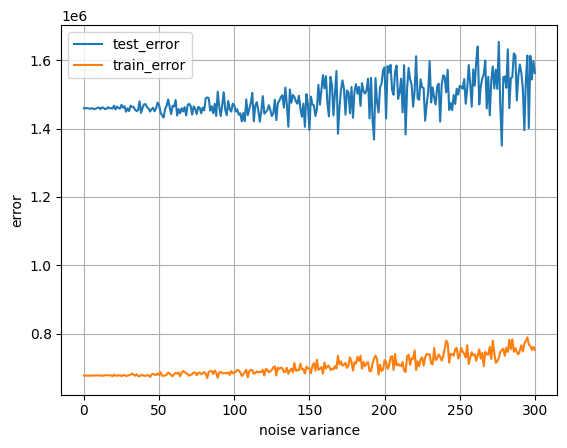

In [6]:
import numpy.linalg as la
import numpy as np
import pandas
import matplotlib.pyplot as plt

path = "/content/bike_sharing_rental.csv"
df = pandas.read_csv(path)

n = len(df)
columns = df.columns[1:-1]

n_train = int(0.8 * n)
n_test = n - n_train
train_data = df[:n_train]
test_data = df[n_train:]

X_train = np.matrix([list(train_data.loc[:, x]) for x in columns]).T
X_test = np.matrix([list(test_data.loc[:, x]) for x in columns]).T

X_seudo_inv = la.inv(X_train.T @ X_train) @ X_train.T# @ y_train

train_error = []
test_error = []
noise_variance = np.linspace(0, 300, 301, endpoint=True)

for variance in noise_variance:
    noise = np.random.normal(0, variance, n)
    y_noisy = df["cnt"] + noise
    y_train = np.matrix(y_noisy[:n_train]).T
    y_test = np.matrix(y_noisy[n_train:]).T

    beta = X_seudo_inv @ y_train

    y_predicted_train = (X_train @ beta)
    y_predicted_test = (X_test @ beta)

    y_test = np.array(y_test.reshape(-1))[0]
    y_train = np.array(y_train.reshape(-1))[0]
    y_predicted_train = np.array(y_predicted_train.reshape(-1))[0]
    y_predicted_test = np.array(y_predicted_test.reshape(-1))[0]

    MSE_train = sum((y_train - y_predicted_train) ** 2) / n_train
    MSE_test = sum((y_test - y_predicted_test) ** 2) / n_test

    train_error.append(MSE_train)
    test_error.append(MSE_test)

plt.plot(noise_variance, test_error, label="test_error")
plt.plot(noise_variance, train_error, label="train_error")
plt.ylabel("error")
plt.xlabel("noise variance")
plt.legend()
plt.grid()  
plt.show()
plt.close()

By increasing variance of noise, Both train error and test errors increase

In [8]:
# backward selection
import numpy.linalg as la 
from sklearn.linear_model import LinearRegression
from scipy import stats

X = np.ones((n, 1))
features = ['intercept']
for x in columns:
    features.append(x)
    X = np.append(X, np.matrix(df.loc[:, x]).T, axis=1)

#columns.insert(0, 'intercept')

def orthogonal_component(A, v):
    return v - A @ la.inv(A.T @ A) @ A.T @ v

#print(X[:,1])
#print(np.delete(X, 1, 1)[0])

selected = []
for i in range(len(columns)+1): 
    cos_min = 1
    index = 0
    for j in range(X.shape[1]):
        x = X[:,j]
        e = orthogonal_component(np.delete(X, j, 1), x)
        cos_tta = float(abs(e.T @ x / (la.norm(e) * la.norm(x))))
        if cos_tta < cos_min:
            cos_min = cos_tta
            index = j
    X = np.delete(X, index, 1)
    selected.append(features[index])
    features.pop(index)

#print(np.matrix(df.loc[:, 'atemp']).T)
X_train = np.empty((n_train+1, 3))
X_test = np.empty((n-n_train, 3))
print(selected)
#print(len(df), n_train)

for i in range(3):
    print(selected[-i-1])
    X_train[:, i] = np.array(df.loc[:n_train, selected[-i-1]]).T
    X_test[:, i] = np.array(df.loc[n_train:, selected[-i-1]]).T

y_train = df.loc[:n_train, "cnt"]
y_test = df.loc[n_train:, "cnt"]

beta = la.inv(X_train.T @ X_train) @ X_train.T @ y_train
print(f"beta: {beta}")

y_predicted_train = np.array((X_train @ beta).reshape(-1))[0]
y_predicted_test = np.array((X_test @ beta).reshape(-1))[0]

MSE_train = sum((y_train - y_predicted_train) ** 2) / n_train
MSE_test = sum((y_test - y_predicted_test) ** 2) / n_test

print(f"MSE train: {MSE_train}, MSE test: {MSE_test}")

['atemp', 'intercept', 'hum', 'season', 'temp', 'weathersit', 'windspeed', 'mnth', 'workingday', 'yr', 'weekday', 'holiday']
holiday
weekday
yr
beta: [1086.89252085  676.52868785 3367.73128645]
MSE train: 3221241.7058723187, MSE test: 4899562.824713067


MSE train: 653206.7965764437
MSE test: 1372259.8436256973


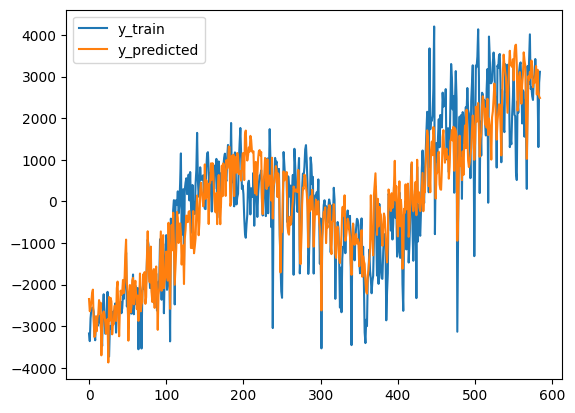

In [11]:
### PCA ###

from numpy import mean

X_train = np.matrix([df.loc[:n_train, x] - mean(df.loc[:n_train, x]) for x in columns]).T
X_test = np.matrix([df.loc[n_train:, x] - mean(df.loc[n_train:, x])for x in columns]).T

y_train = df.loc[:n_train, "cnt"] - mean(df.loc[:n_train, "cnt"])
y_test = df.loc[n_train:, "cnt"] - mean(df.loc[n_train:, "cnt"])

cov = np.cov(X_train.T)
eig_values , eig_vectors = la.eig(cov)
PC = eig_vectors[:-1]
U_train = X_train @ PC.T
U_test = X_test @ PC.T

beta = la.inv(U_train.T @ U_train) @ U_train.T @ y_train

y_predicted_train = np.array((U_train @ beta).reshape(-1))[0]
y_predicted_test = np.array((U_test @ beta).reshape(-1))[0]

MSE_train = sum((y_train - y_predicted_train) ** 2) / n_train
MSE_test = sum((y_test - y_predicted_test) ** 2) / n_test

print(f"MSE train: {MSE_train}")
print(f"MSE test: {MSE_test}")
plt.plot(y_train, label='y_train')
plt.plot(y_predicted_train, label='y_predicted')
plt.legend()
plt.show()

R^2 score: [-0.006786568038102958, 0.10943684920649888, 0.10691079457254571, 0.14533491877604388, 0.14221088670463344, 0.8531138837905556, 0.8531120494980413, 0.9338163099901037, 0.9065032481478489, 0.8875376959555185]
MSE valid: [0.5153260147615069, 0.4558367919887635, 0.45712975884878193, 0.4374622827171968, 0.43906132570054157, 0.0751839955885703, 0.07518493447540218, 0.03387627357948628, 0.0478565269489085, 0.05756408835198742]


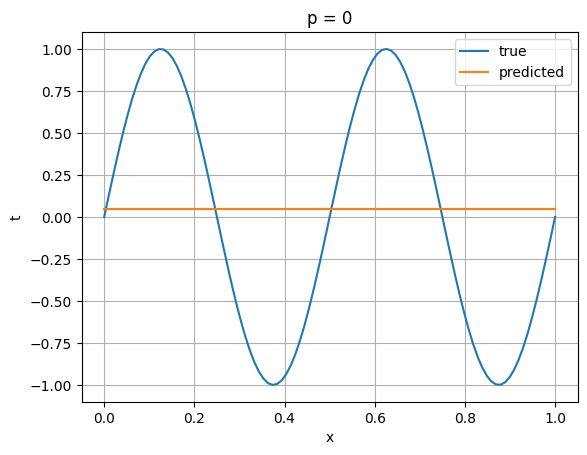

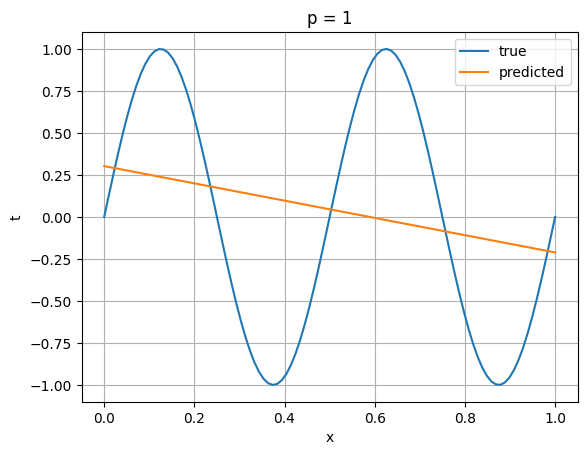

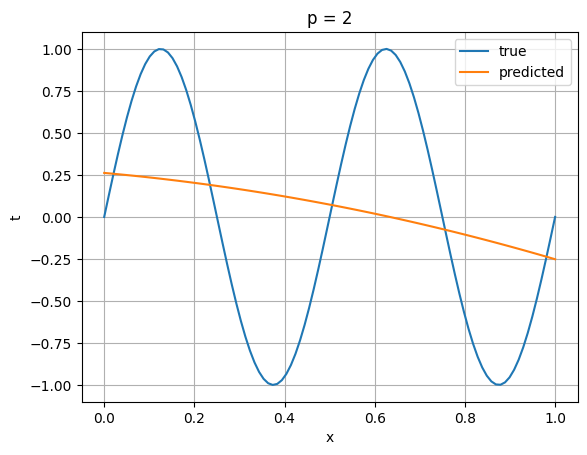

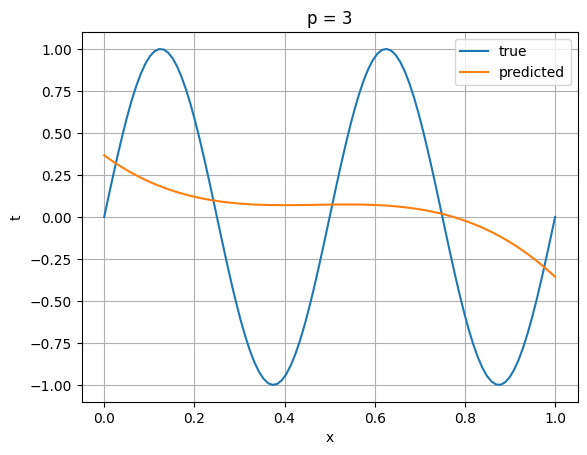

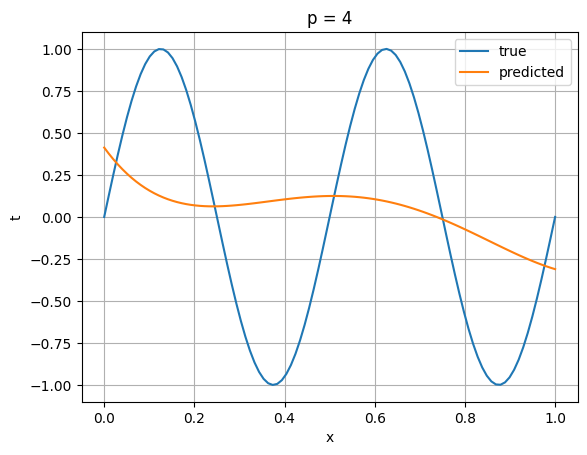

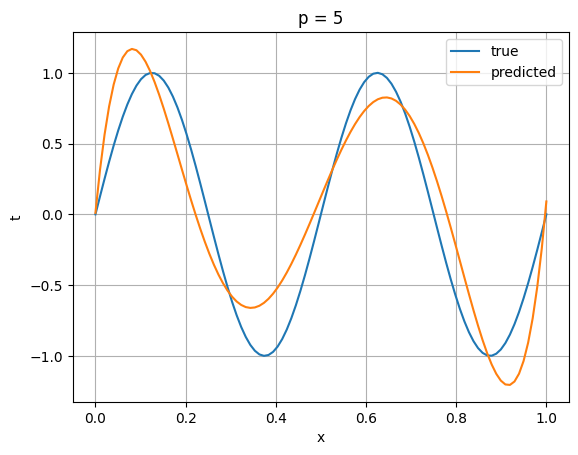

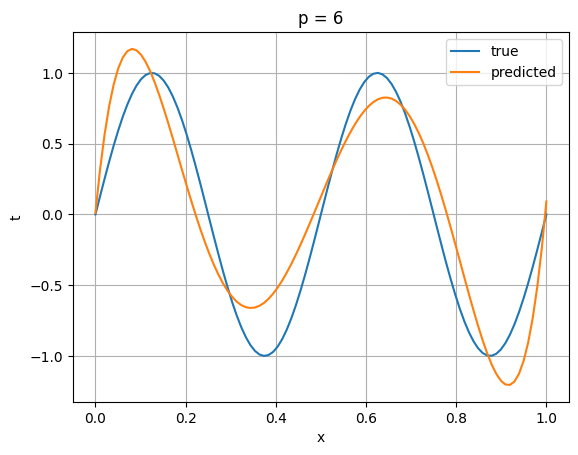

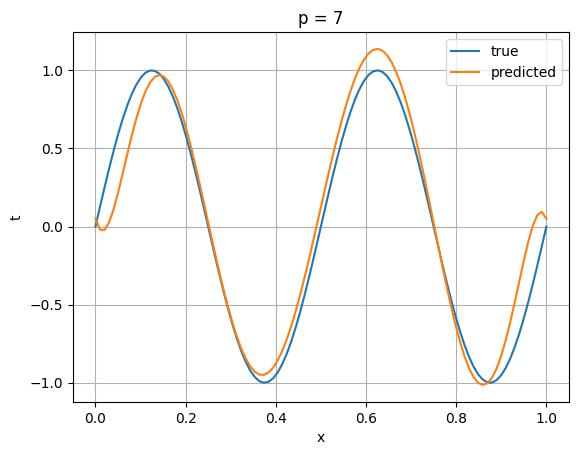

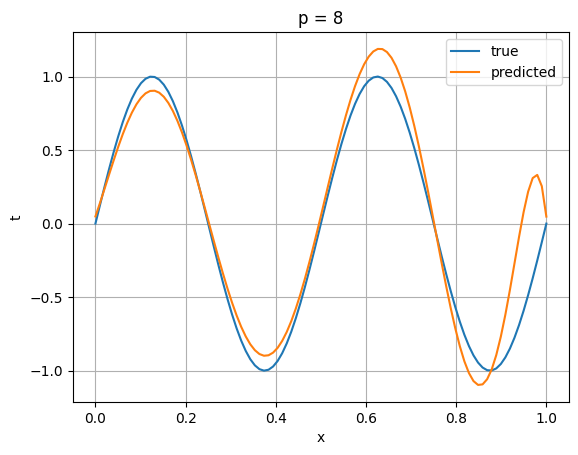

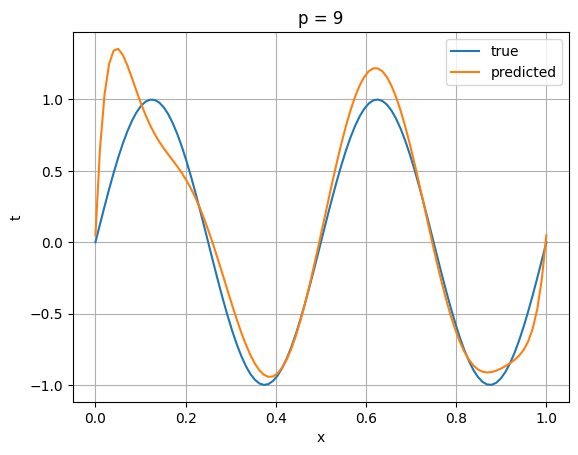

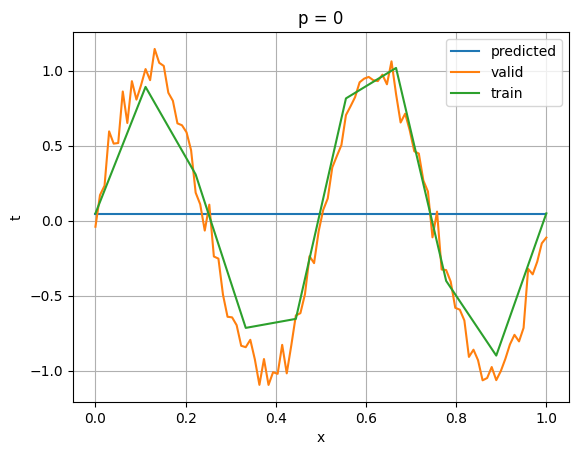

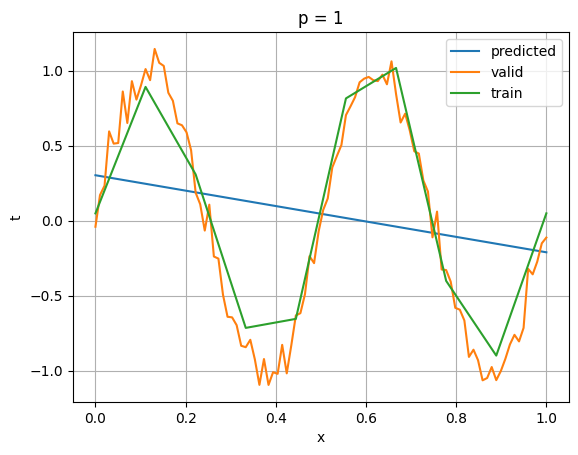

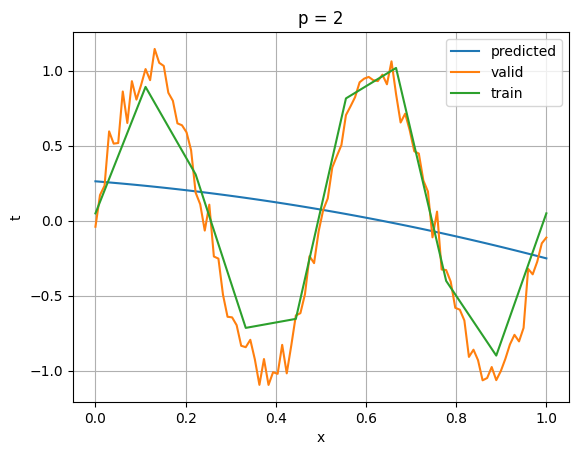

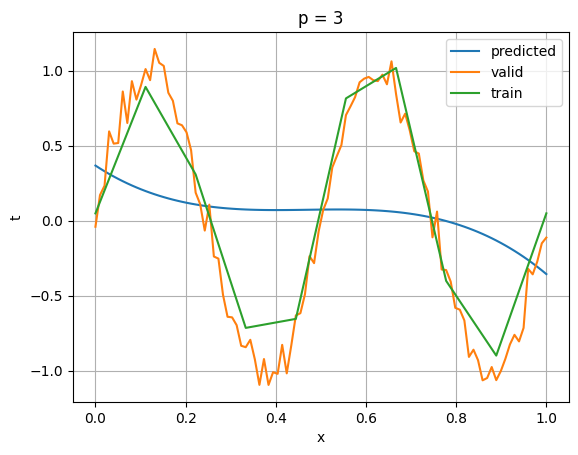

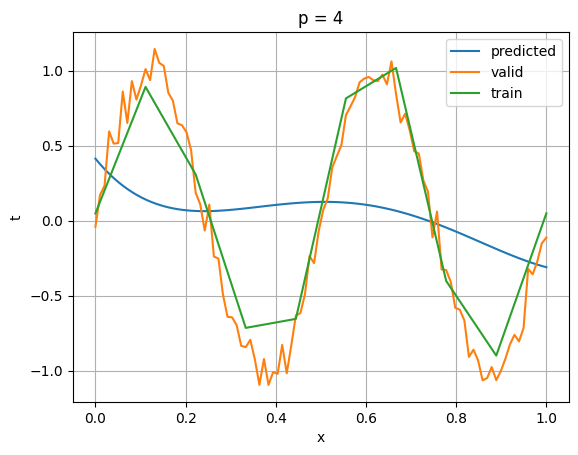

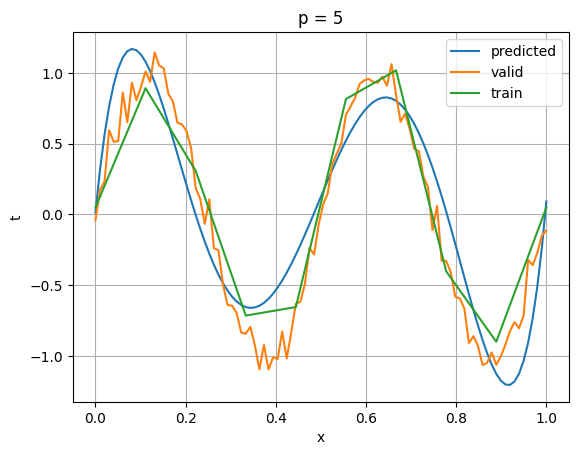

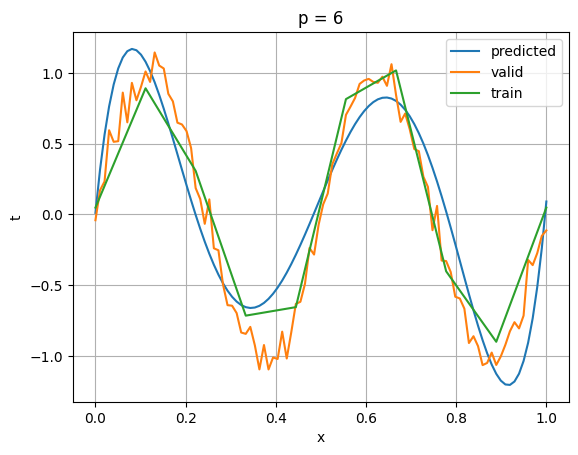

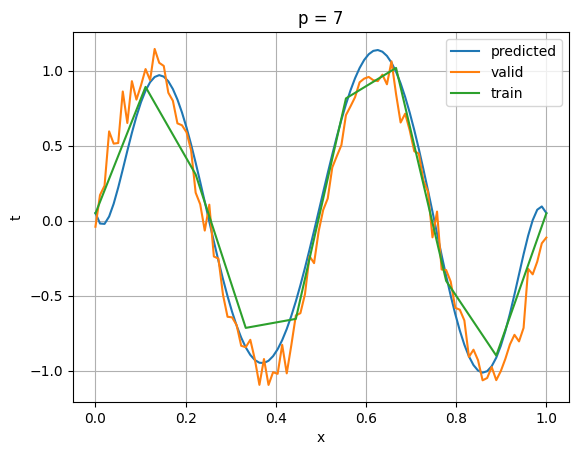

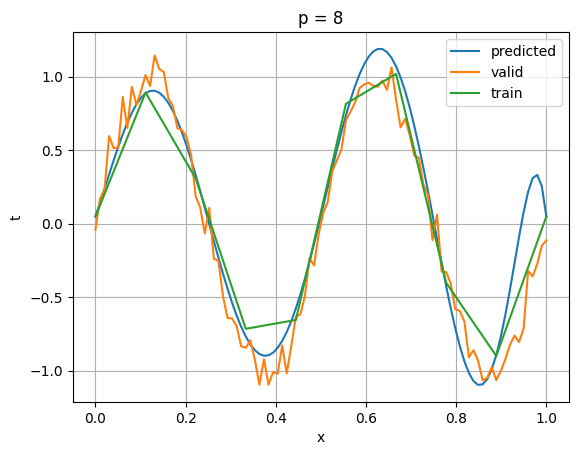

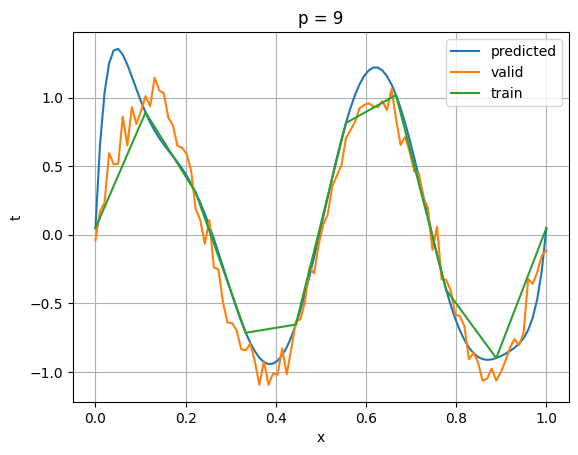

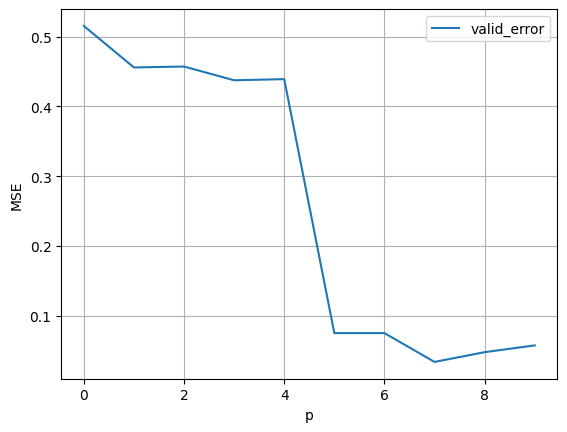

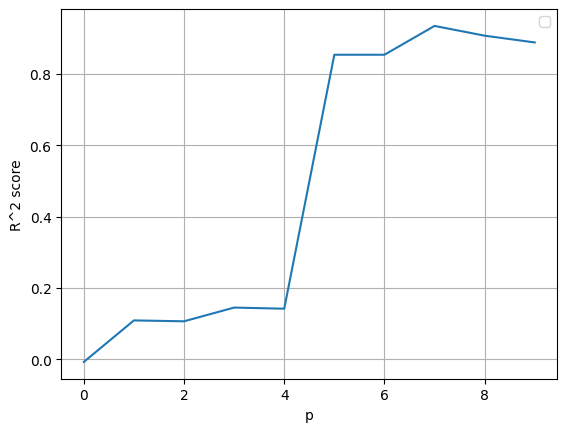

R


In [13]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error


n_train = 10
n_valid = 100

x_train = np.linspace(0, 1, n_train, endpoint=True)
x_valid = np.linspace(0, 1, n_valid, endpoint=True)

sigma  = 0.09
t_train = np.sin(4 * np.pi * x_train) + np.random.normal(0, sigma, n_train)
t_valid = np.sin(4 * np.pi * x_valid) + np.random.normal(0, sigma, n_valid)

T_train_predicted = []
T_valid_predicted = []
R2_score = []
MSE_valid = []

for i in range(10):
    X_train = np.array([x_train**k for k in range(i+1)]).T
    X_valid = np.array([x_valid**k for k in range(i+1)]).T
    model = LinearRegression().fit(X_train, t_train) 

    t_valid_predicted = model.predict(X_valid)
    T_train_predicted.append(model.predict(X_train))
    T_valid_predicted.append(t_valid_predicted)
    R2_score.append(r2_score(t_valid, t_valid_predicted))
    MSE_valid.append(mean_squared_error(t_valid, t_valid_predicted))

print(f"R^2 score: {R2_score}")
print(f"MSE valid: {MSE_valid}")

for i in range(10):
      #plt.subplot(len(T_predicted), 1, i+1)
      plt.title(f"p = {i}")
      plt.ylabel("t")
      plt.xlabel("x")
      plt.plot(x_valid, np.sin(4 * np.pi * x_valid), label='true')
      plt.plot(x_valid, T_valid_predicted[i], label='predicted')
      plt.legend()
      plt.grid()  
      plt.show()
      plt.close()


for i in range(10):
      #plt.subplot(len(T_predicted), 1, i+1)
      plt.title(f"p = {i}")
      plt.ylabel("t")
      plt.xlabel("x")
      plt.plot(x_valid, T_valid_predicted[i], label='predicted')
      plt.plot(x_valid, t_valid, label='valid')
      plt.plot(x_train, t_train, label='train')
      plt.legend()
      plt.grid()  
      plt.show()
      plt.close()


plt.ylabel("MSE")
plt.xlabel("p")
x = list(range(0, 10))
#plt.plot(x, MSE_train, label='train_error')
plt.plot(x, MSE_valid, label='valid_error')
plt.legend()
plt.grid()  
plt.show()
plt.close()

plt.ylabel("R^2 score")
plt.xlabel("p")
x = list(range(0, 10))

plt.plot(x, R2_score)
plt.legend()
plt.grid()  
plt.show()
plt.close()

"""
low R^2 score indicates underfitted or overfitted model, On the other hand
R^2 score close to 1 indicates a perfect model
"""

print("low R^2 score indicates ")

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.551e+00, tolerance: 4.484e-04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.551e+00, tolerance: 4.484e-04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.551e+00, tolerance: 4.484e-04

alpha ridge best: 1.0699320537907195e-13
alpha lasso best: 3.8337599924474724e-13


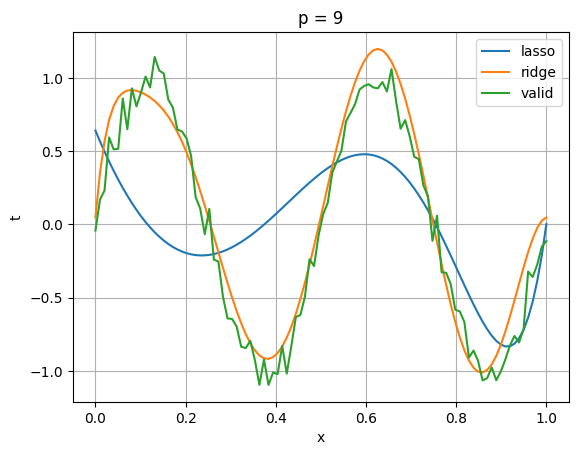

In [22]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import numpy as np

r2_max_lasso = -10
r2_max_ridge = -10
alpha_ridge = 0
alpha_lasso = 0
t_l = []
t_r = []

alpha = 0.00000000000001
for m in range(20):
    alpha *= 1.2
    X_train = np.array([x_train**k for k in range(10)]).T
    X_valid = np.array([x_valid**k for k in range(10)]).T
    lasso_model = Lasso(alpha=alpha).fit(X_train, t_train)
    ridge_model = Ridge(alpha=alpha).fit(X_train, t_train) 

    t_predicted_lasso = lasso_model.predict(X_valid)
    t_predicted_ridge = ridge_model.predict(X_valid)  


    lasso_r2 = r2_score(t_valid, t_predicted_lasso)
    ridge_r2 = r2_score(t_valid, t_predicted_ridge)


    if lasso_r2 > r2_max_lasso:
        r2_max_lasso = lasso_r2
        alpha_lasso = alpha 
        t_l = t_predicted_lasso
    if ridge_r2 > r2_max_ridge:
        r2_max_ridge = ridge_r2
        alpha_ridge = alpha          
        t_r = t_predicted_ridge



    MSE_train = [np.linalg.norm(T_train_predicted[i] - t_train[i])**2 / n_train for i in range(10)]
    MSE_valid = [np.linalg.norm(T_valid_predicted[i] - t_valid[i])**2 / n_valid for i in range(10)]

    #print(f"R^2 score: {R2_score}")
    #print(f"MSE valid: {MSE_valid}")

print(f"alpha ridge best: {alpha_ridge}")
print(f"alpha lasso best: {alpha_lasso}")

plt.title(f"p = {9}")
plt.ylabel("t")
plt.xlabel("x")
plt.plot(x_valid, t_l, label='lasso')
plt.plot(x_valid, t_r, label='ridge')
plt.plot(x_valid, t_valid, label='valid')
#plt.plot(x_train, t_train, label='train')
plt.legend()
plt.grid()  
plt.show()
plt.close()

alpha ridge best: 1.0699320537907195e-13

alpha lasso best: 3.8337599924474724e-13

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.551e+00, tolerance: 4.484e-04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.551e+00, tolerance: 4.484e-04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.551e+00, tolerance: 4.484e-04

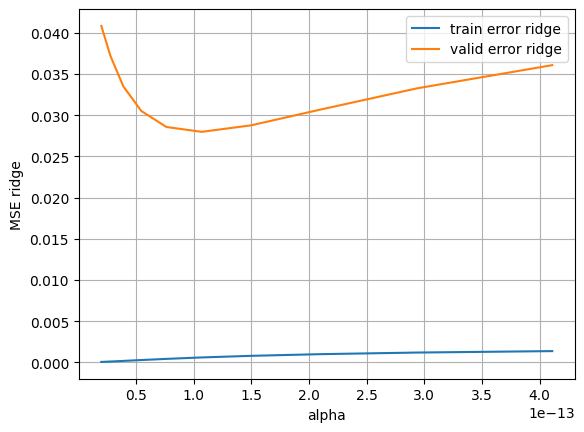

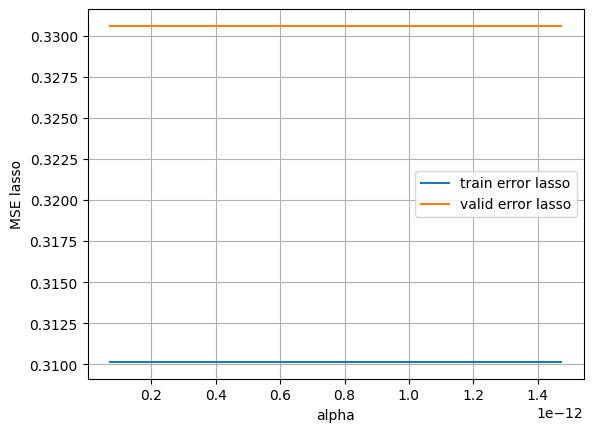

In [28]:
T_train_predicted = []
T_valid_predicted = []
R2_score = []
MSE_lasso_valid = []
MSE_lasso_train = []
MSE_ridge_valid = []
MSE_ridge_train = []
AL = []
AR = []

alpha_l = (1.4)**(-5) * alpha_lasso
alpha_r = (1.4)**(-5) * alpha_ridge

for m in range(10):

    X_train = np.array([x_train**k for k in range(10)]).T
    X_valid = np.array([x_valid**k for k in range(10)]).T
    lasso_model = Lasso(alpha=alpha_l).fit(X_train, t_train)
    ridge_model = Ridge(alpha=alpha_r).fit(X_train, t_train) 

    t_valid_lasso = lasso_model.predict(X_valid)
    t_valid_ridge = ridge_model.predict(X_valid)
    t_train_lasso = lasso_model.predict(X_train)
    t_train_ridge = ridge_model.predict(X_train)

    MSE_lasso_valid.append(mean_squared_error(t_valid, t_valid_lasso))
    MSE_lasso_train.append(mean_squared_error(t_train, t_train_lasso))

    MSE_ridge_valid.append(mean_squared_error(t_valid, t_valid_ridge))
    MSE_ridge_train.append(mean_squared_error(t_train, t_train_ridge))

    AL.append(alpha_l)
    AR.append(alpha_r)

    alpha_l *= 1.4
    alpha_r *= 1.4


plt.ylabel("MSE ridge")
plt.xlabel("alpha")
x = list(range(0, 10))
plt.plot(AR, MSE_ridge_train, label='train error ridge')
plt.plot(AR, MSE_ridge_valid, label='valid error ridge')
plt.legend()
plt.grid()  
plt.show()
plt.close()


plt.ylabel("MSE lasso")
plt.xlabel("alpha")
x = list(range(0, 10))
plt.plot(AL, MSE_lasso_train, label='train error lasso')
plt.plot(AL, MSE_lasso_valid, label='valid error lasso')
plt.legend()
plt.grid()  
plt.show()
plt.close()